In [1]:
import tensorflow as tf
# encoding=utf8  
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'

# 下载数据集
def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    # 获取文件相关属性
    statinfo = os.stat(filename)
    # 比对文件的大小是否正确
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

# 单词表
words = read_data(filename)

# Data size
print('Data size', len(words))

Found and verified text8.zip
Data size 17005207


In [3]:
# Step 2: Build the dictionary and replace rare words with UNK token.
# 只留50000个单词，其他的词都归为UNK
vocabulary_size = 50000

def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    # extend追加一个列表
    # Counter用来统计每个词出现的次数
    # most_common返回一个TopN列表，只留50000个单词包括UNK  
    # c = Counter('abracadabra')
    # c.most_common()
    # [('a', 5), ('r', 2), ('b', 2), ('c', 1), ('d', 1)]
    # c.most_common(3)
    # [('a', 5), ('r', 2), ('b', 2)]
    # 前50000个出现次数最多的词
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # 生成 dictionary，词对应编号, word:id(0-49999)
    # 词频越高编号越小
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    # data把数据集的词都编号
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    # 记录UNK词的数量
    count[0][1] = unk_count
    # 编号对应词的字典
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

# data 数据集，编号形式
# count 前50000个出现次数最多的词
# dictionary 词对应编号
# reverse_dictionary 编号对应词
data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])


Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5242, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [4]:
data_index = 0
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    # [ skip_window target skip_window ]
            # [ skip_window target skip_window ]
                    # [ skip_window target skip_window ]
            
#     [0 1 2 3 4 5 6 7 8 9 ...]
#            t     i  
    # 循环3次
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # 获取batch和labels
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        # 循环2次，一个目标单词对应两个上下文单词
        #num_skips 在定义窗口大小和方向时已确定
        for j in range(num_skips):
            while target in targets_to_avoid:
                # 可能先拿到前面的单词也可能先拿到后面的单词
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    # 回溯3个词。因为执行完一个batch的操作之后，data_index会往右多偏移span个位置
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

# 打印sample data
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])


3081 originated -> 12 as
3081 originated -> 5242 anarchism
12 as -> 3081 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


In [5]:
# Step 4: Build and train a skip-gram model.
batch_size = 128
# 词向量维度
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
# 从0-100抽取16个整数，无放回抽样
valid_examples = np.random.choice(valid_window, valid_size, replace=False) 
# 负采样样本数
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
#     with tf.device('/cpu:0'):
        # 词向量
        # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # embedding_lookup(params,ids)其实就是按照ids顺序返回params中的第ids行
    # 比如说，ids=[1,7,4],就是返回params中第1,7,4行。返回结果为由params的1,7,4行组成的tensor
    # 提取要训练的词
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the noise-contrastive estimation(NCE) loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_labels,
                       inputs=embed,
                       num_sampled=num_sampled,   
                       num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    # 抽取一些常用词来测试余弦相似度
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    # valid_size == 16
    # [16,1] * [1*50000] = [16,50000]
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
# Step 5: Begin training.
num_steps = 100001
final_embeddings = []

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        # 获取一个批次的target，以及对应的labels，都是编号形式的
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        # 计算训练2000次的平均loss
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
    
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()
            # 计算验证集的余弦相似度最高的词
            for i in xrange(valid_size):
                # 根据id拿到对应单词
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                # 从大到小排序，排除自己本身，取前top_k个值
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    # 训练结束得到的词向量
    final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  270.7310485839844
Nearest to as: curonian, theory, conjectured, obligations, calder, iconoclast, crack, heart,
Nearest to no: isaac, traceable, wmd, temperament, scandinavia, monarchists, clinched, ethic,
Nearest to other: ruhr, hybridized, perp, parentage, catholicism, xxxiv, erythromycin, japh,
Nearest to all: bottlenecks, imperative, residency, wray, sydney, gravis, fated, haul,
Nearest to had: litovsk, setbacks, creutzfeldt, coincided, triples, chordal, pluralist, barker,
Nearest to four: instructing, biafra, india, cyclic, wight, olivia, clothed, brigid,
Nearest to history: varicella, wheeler, grinnell, identifies, silverstein, bigelow, inst, unconditionally,
Nearest to they: multiplex, laplace, minestrone, shop, stromata, cultivar, insure, rare,
Nearest to not: smart, bureaucracy, figurines, albret, rep, anions, lorica, reichstag,
Nearest to zero: horseshoes, kayak, juror, protestors, christiane, giotto, lollard, categorize,
Nearest to his: 

Average loss at step  82000 :  4.788048763990402
Average loss at step  84000 :  4.756296545147896
Average loss at step  86000 :  4.76735711145401
Average loss at step  88000 :  4.735437424659729
Average loss at step  90000 :  4.730326668143272
Average loss at step  92000 :  4.656307264089584
Average loss at step  94000 :  4.713107255101204
Average loss at step  96000 :  4.693037749767304
Average loss at step  98000 :  4.590863627076149
Average loss at step  100000 :  4.701929095983505
Nearest to as: peacocks, kapoor, ursus, recitative, when, apatosaurus, by, brahma,
Nearest to no: bacilli, temperament, any, a, brotherhood, ethic, there, overt,
Nearest to other: various, many, including, ize, some, ensign, different, cayuga,
Nearest to all: many, these, any, some, both, ursus, two, three,
Nearest to had: has, have, was, were, busan, kanem, been, since,
Nearest to four: five, three, seven, six, eight, two, nine, zero,
Nearest to history: ursus, disembodied, vivian, akimbo, list, region, 

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


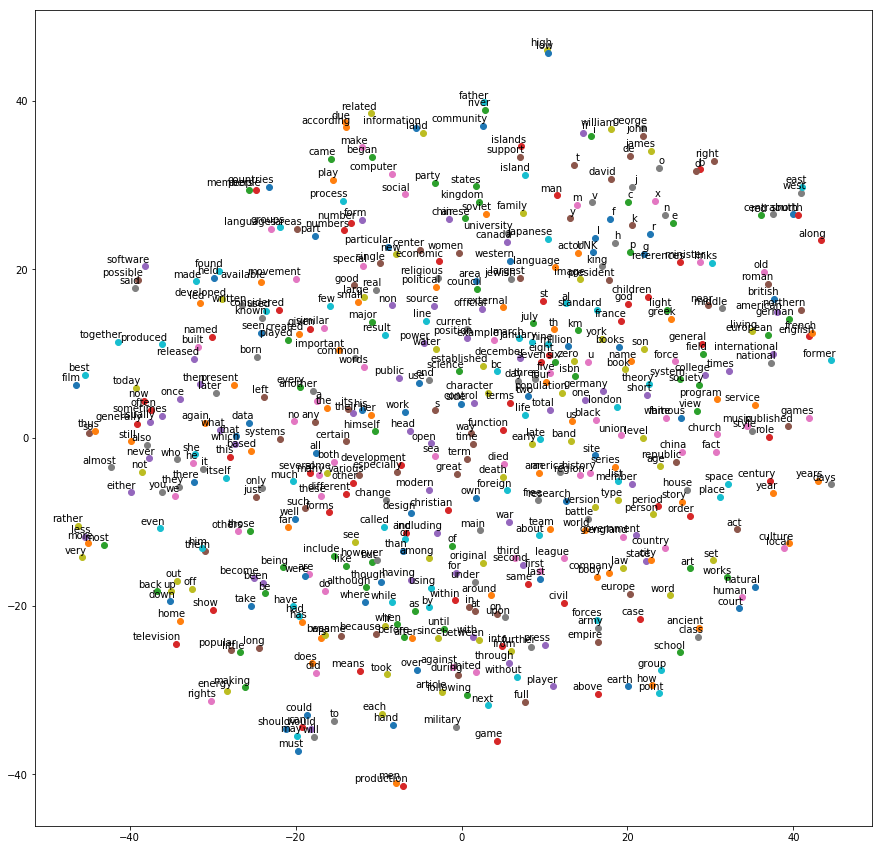

In [9]:
# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    # 设置图片大小
    plt.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    %matplotlib inline

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')# mac：method='exact'
    # 画500个点
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [10]:
with tf.Session() as session:
    valid_word = "name"
    valid_examples = dictionary[valid_word]
    valid_dataset = tf.constant([valid_examples], dtype=tf.int32)
    valid_embeddings = tf.nn.embedding_lookup(final_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, final_embeddings, transpose_b=True)
    sim = similarity.eval()

    top_k = 8  # number of nearest neighbors
    nearest = (-sim[0]).argsort()[1:top_k + 1]# 排除自己本身，从小到大排序
    log_str = "Nearest to %s:" % valid_word
    for k in xrange(top_k):
        close_word = reverse_dictionary[nearest[k]]
        log_str = "%s %s," % (log_str, close_word)
    print(log_str)

Nearest to name: bckgr, rest, calculus, perjury, understanding, obliged, leno, correct,
